   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.2 MB/s eta 0:00:00
✅ Library berhasil diimport!
📊 Siap untuk melakukan Fuzzy C-Means Clustering

🔄 Upload file Excel Anda...


Saving Nama_BMI_TDS_TDD_KGD_MAP_PP.xlsx to Nama_BMI_TDS_TDD_KGD_MAP_PP.xlsx
📁 File 'Nama_BMI_TDS_TDD_KGD_MAP_PP.xlsx' berhasil diupload!

📋 INFORMASI DATA:
Jumlah baris: 90
Jumlah kolom: 7
Kolom yang tersedia: ['Nama', 'BMI', 'TDS', 'TDD', 'KGD', 'MAP', 'PP']

📊 PREVIEW DATA:
        Nama        BMI  TDS  TDD  KGD         MAP  PP
0   JEMATUN   18.017206  136   80  167   98.666667  56
1  KHODIJAH   17.777778  110   70  126   83.333333  40
2      WARTI  27.407657  120   70  141   86.666667  50
3    KATINAH  26.912726  136   76   89   96.000000  60
4    KAYATIN  28.827530  154   73  200  100.000000  81

🔍 MISSING VALUES:
Nama    0
BMI     0
TDS     0
TDD     0
KGD     0
MAP     0
PP      0
dtype: int64

📈 STATISTIK DESKRIPTIF:
             BMI         TDS         TDD         KGD         MAP         PP
count  90.000000   90.000000   90.000000   90.000000   90.000000  90.000000
mean   21.239388  126.300000   75.633333  142.855556   92.522222  50.666667
std     3.282368   24.405493   13.9810

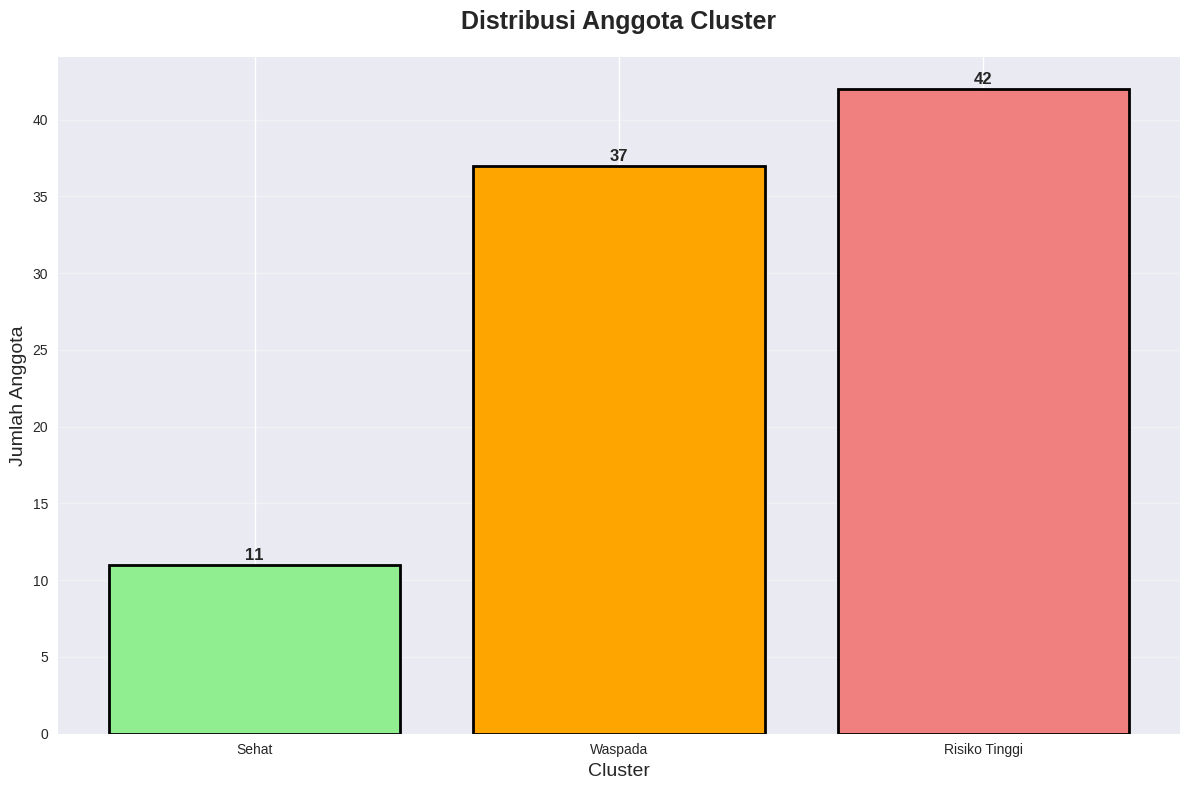

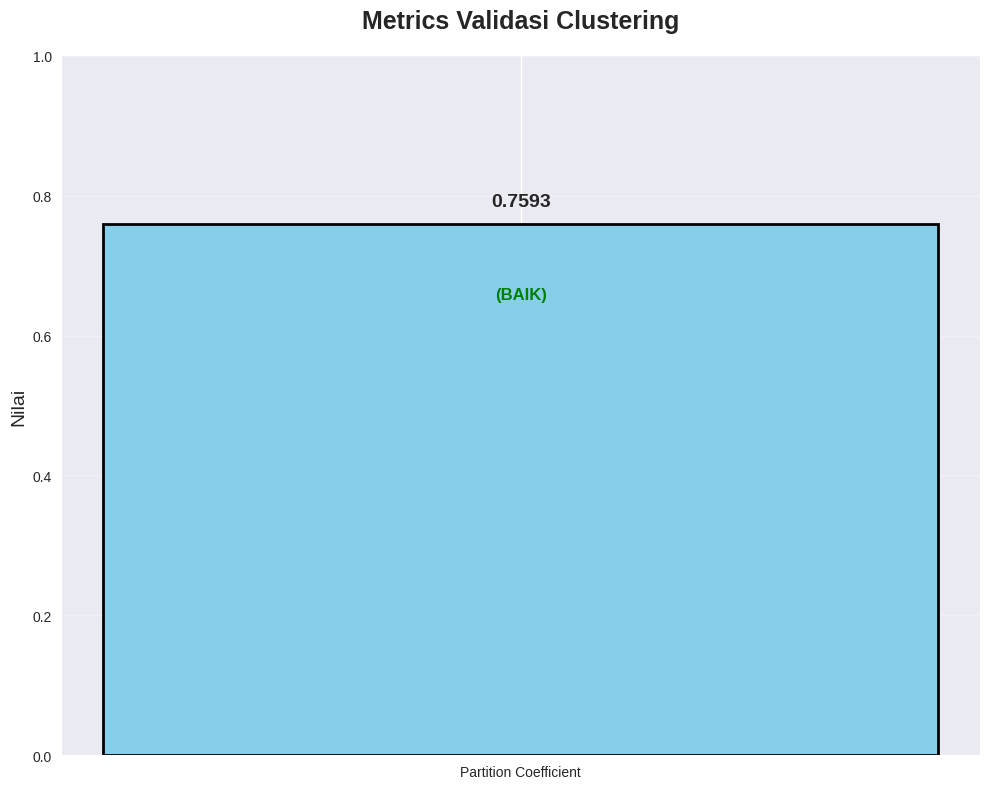

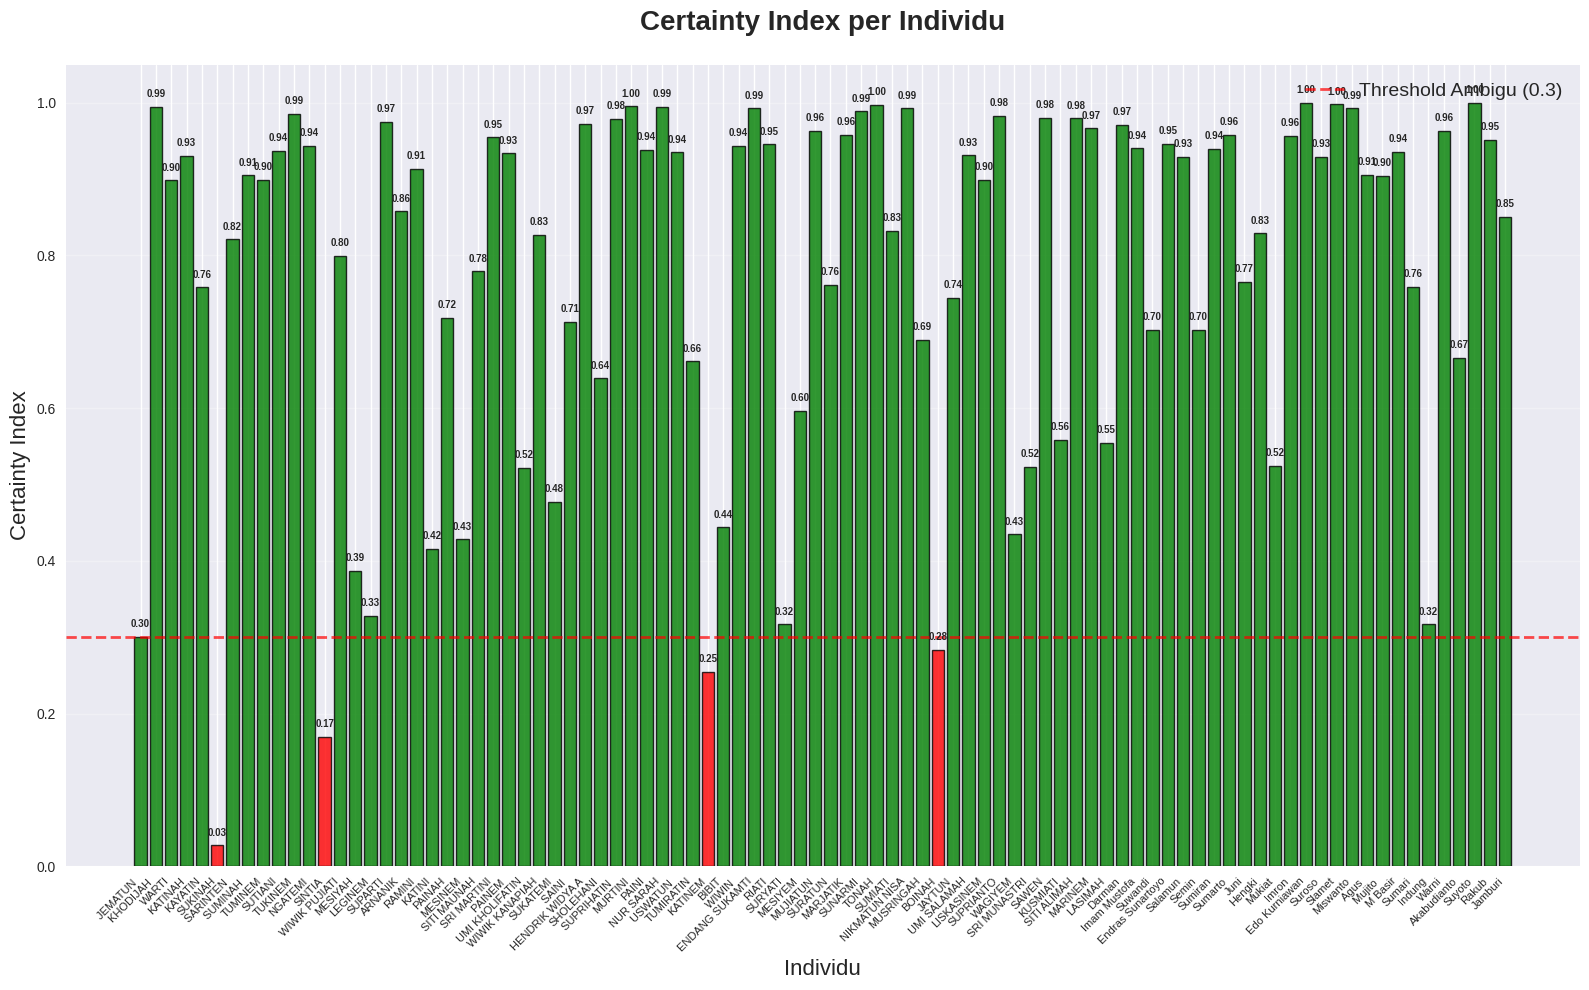


📋 LAPORAN RINGKASAN CLUSTERING:
📊 Jumlah Data: 90
🎯 Jumlah Cluster: 3
🔧 Parameter Fuzziness (m): 1.5
📈 Partition Coefficient: 0.7593 (BAIK)
⚠️  Data Ambigu: 4 dari 90

🏥 DISTRIBUSI CLUSTER:
   Sehat: 11 orang (12.2%)
   Waspada: 37 orang (41.1%)
   Risiko Tinggi: 42 orang (46.7%)

💡 REKOMENDASI:
   - PC sudah baik, clustering berkualitas tinggi!
   - Perhatikan 4 data dengan keanggotaan ambigu
   - Pertimbangkan feature engineering atau clustering ulang

✅ Analisis selesai!

💾 MENYIMPAN HASIL...
✅ Hasil disimpan ke 'hasil_fuzzy_clustering.csv'
✅ Detail PC disimpan ke 'detail_partition_coefficient.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
# ===== INSTALASI LIBRARY =====
!pip install scikit-fuzzy pandas numpy matplotlib seaborn openpyxl

# ===== IMPORT LIBRARY =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import skfuzzy as fuzz
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# ===== SETUP DISPLAY =====
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')

print("✅ Library berhasil diimport!")
print("📊 Siap untuk melakukan Fuzzy C-Means Clustering")

# ===== UPLOAD DATA =====
print("\n🔄 Upload file Excel Anda...")
uploaded = files.upload()

# Ambil nama file yang diupload
filename = list(uploaded.keys())[0]
print(f"📁 File '{filename}' berhasil diupload!")

# ===== LOAD DATA =====
# Baca data Excel
df = pd.read_excel(filename)

# Tampilkan informasi dasar data
print(f"\n📋 INFORMASI DATA:")
print(f"Jumlah baris: {df.shape[0]}")
print(f"Jumlah kolom: {df.shape[1]}")
print(f"Kolom yang tersedia: {list(df.columns)}")

# Tampilkan 5 baris pertama
print(f"\n📊 PREVIEW DATA:")
print(df.head())

# Cek missing values
print(f"\n🔍 MISSING VALUES:")
print(df.isnull().sum())

# Statistik deskriptif
print(f"\n📈 STATISTIK DESKRIPTIF:")
print(df.describe())

# ===== PREPROCESSING DATA =====
print("\n🔧 PREPROCESSING DATA...")

# Pisahkan kolom nama dan fitur numerik
nama_column = 'Nama'
feature_columns = ['BMI', 'TDS', 'TDD', 'KGD', 'MAP', 'PP']

# Pastikan kolom yang dibutuhkan ada
missing_cols = [col for col in [nama_column] + feature_columns if col not in df.columns]
if missing_cols:
    print(f"❌ Kolom yang hilang: {missing_cols}")
    print("Silakan periksa nama kolom pada file Excel Anda!")
else:
    print("✅ Semua kolom yang dibutuhkan tersedia!")

    # Ambil data fitur untuk clustering
    X = df[feature_columns].copy()
    names = df[nama_column].copy()

    # Cek dan handle missing values
    if X.isnull().sum().sum() > 0:
        print("⚠️  Mengisi missing values dengan median...")
        X = X.fillna(X.median())

    # Standardisasi data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print(f"📊 Data siap untuk clustering!")
    print(f"Shape data: {X_scaled.shape}")

# ===== FUNGSI UNTUK MENGHITUNG PARTITION COEFFICIENT =====
def calculate_partition_coefficient(membership_matrix):
    """
    Menghitung Partition Coefficient (PC)
    PC = (1/N) * sum(sum(uij^2))

    Parameters:
    membership_matrix: array, matriks keanggotaan fuzzy

    Returns:
    float: nilai PC (0-1)
    """
    N = membership_matrix.shape[1]  # jumlah data
    pc = np.sum(membership_matrix ** 2) / N
    return pc

def calculate_partition_entropy(membership_matrix):
    """
    Menghitung Partition Entropy (PE)
    PE = -(1/N) * sum(sum(uij * log(uij)))

    Parameters:
    membership_matrix: array, matriks keanggotaan fuzzy

    Returns:
    float: nilai PE
    """
    N = membership_matrix.shape[1]  # jumlah data
    # Hindari log(0) dengan menambahkan epsilon kecil
    epsilon = 1e-10
    membership_safe = np.maximum(membership_matrix, epsilon)
    pe = -np.sum(membership_matrix * np.log(membership_safe)) / N
    return pe

def interpret_pc(pc_value):
    """Interpretasi nilai Partition Coefficient"""
    if pc_value > 0.7:
        return "BAIK", "green"
    elif pc_value > 0.5:
        return "CUKUP", "orange"
    else:
        return "BURUK", "red"

# ===== FUZZY C-MEANS CLUSTERING =====
print("\n🎯 MELAKUKAN FUZZY C-MEANS CLUSTERING...")

# Parameter clustering
n_clusters = 3  # Sehat, Waspada, Risiko Tinggi
fuzziness = 1.5  # Parameter m (fuzziness coefficient)
max_iter = 300
error_threshold = 1e-5

# Lakukan clustering
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    X_scaled.T,
    n_clusters,
    fuzziness,
    error=error_threshold,
    maxiter=max_iter,
    init=None
)

print(f"✅ Clustering selesai!")
print(f"📊 Jumlah iterasi: {p}")

# ===== ANALISIS HASIL CLUSTERING =====
print("\n📊 ANALISIS HASIL CLUSTERING...")

# Tentukan cluster untuk setiap data (hard assignment)
cluster_labels = np.argmax(u, axis=0)

# Buat nama cluster yang meaningful
cluster_names = ['Sehat', 'Waspada', 'Risiko Tinggi']

# Hitung metrics
pc = calculate_partition_coefficient(u)
pe = calculate_partition_entropy(u)
pc_category, pc_color = interpret_pc(pc)

print(f"🔢 METRICS VALIDASI:")
print(f"   Partition Coefficient (PC): {pc:.4f} ({pc_category})")

# ===== TABEL HASIL KEANGGOTAAN =====
print("\n📋 TABEL KEANGGOTAAN FUZZY:")

# Buat DataFrame hasil
results_df = pd.DataFrame({
    'Nama': names,
    'Cluster_Assigned': [cluster_names[i] for i in cluster_labels],
    'Cluster_Sehat': u[0],
    'Cluster_Waspada': u[1],
    'Cluster_Risiko_Tinggi': u[2]
})

# Urutkan berdasarkan cluster
results_df = results_df.sort_values('Cluster_Assigned')

# Tampilkan tabel
print(results_df.round(3))

# ===== ANALISIS DETAILED PARTITION COEFFICIENT =====
print(f"\n🔍 ANALISIS DETAIL PARTITION COEFFICIENT:")
print(f"{'='*60}")

# Hitung kontribusi setiap individu terhadap PC
individual_contributions = np.sum(u**2, axis=0)
pc_manual = np.mean(individual_contributions)

print(f"PC (Manual): {pc_manual:.4f}")
print(f"PC (Fungsi custom): {pc:.4f}")

# Tabel detail perhitungan PC
pc_detail_df = pd.DataFrame ({
    'Nama': names,
    'Sehat²': u[0]**2,
    'Waspada²': u[1]**2,
    'Risiko_Tinggi²': u[2]**2,
    'Total_Kontribusi': individual_contributions,
    'Certainty_Index': (np.max(u, axis=0) - np.partition(u, -2, axis=0)[-2]) / np.max(u, axis=0)
})

print(f"\n📊 TABEL DETAIL PERHITUNGAN PC:")
print(pc_detail_df.round(4))

# Identifikasi data dengan keanggotaan ambigu
ambiguous_threshold = 0.3
ambiguous_data = pc_detail_df[pc_detail_df['Certainty_Index'] < ambiguous_threshold]

if len(ambiguous_data) > 0:
    print(f"\n⚠️  DATA DENGAN KEANGGOTAAN AMBIGU (Certainty < {ambiguous_threshold}):")
    print(ambiguous_data[['Nama', 'Certainty_Index']].round(3))
else:
    print(f"\n✅ Tidak ada data dengan keanggotaan ambigu!")

# ===== VISUALISASI =====
print(f"\n📈 MEMBUAT VISUALISASI...")

# Plot 1: Distribusi Cluster - Grafik terpisah dengan ukuran besar
plt.figure(figsize=(12, 8))
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
colors = ['lightgreen', 'orange', 'lightcoral']
bars = plt.bar([cluster_names[i] for i in cluster_counts.index],
               cluster_counts.values, color=colors, edgecolor='black', linewidth=2)
plt.title('Distribusi Anggota Cluster', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Jumlah Anggota', fontsize=14)
plt.xlabel('Cluster', fontsize=14)
for bar, count in zip(bars, cluster_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             str(count), ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 2: Partition Coefficient Analysis - Grafik terpisah dengan ukuran besar
plt.figure(figsize=(10, 8))
metrics = ['Partition Coefficient']
values = [pc]
colors_metrics = ['skyblue']
bars = plt.bar(metrics, values, color=colors_metrics, edgecolor='black', linewidth=2, width=0.6)
plt.title('Metrics Validasi Clustering', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('Nilai', fontsize=14)
plt.ylim(0, 1)
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=14)
    # Tambahkan interpretasi
    if value > 0.7:
        interpretation = "BAIK"
        color_text = 'green'
    elif value > 0.5:
        interpretation = "CUKUP"
        color_text = 'orange'
    else:
        interpretation = "BURUK"
        color_text = 'red'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() - 0.1,
             f'({interpretation})', ha='center', va='center',
             fontweight='bold', fontsize=12, color=color_text)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Plot 3: Certainty Index - DIPERBAIKI dengan teks yang lebih kecil dan tidak bertumpuk
plt.figure(figsize=(16, 10))
certainty_values = pc_detail_df['Certainty_Index'].values
x_positions = range(len(certainty_values))

# Tentukan warna berdasarkan threshold
bar_colors = ['red' if x < 0.3 else 'green' for x in certainty_values]
bars = plt.bar(x_positions, certainty_values, color=bar_colors,
               edgecolor='black', linewidth=1, alpha=0.8)

plt.title('Certainty Index per Individu', fontsize=20, fontweight='bold', pad=25)
plt.xlabel('Individu', fontsize=16)
plt.ylabel('Certainty Index', fontsize=16)

# Garis threshold
plt.axhline(y=0.3, color='red', linestyle='--', alpha=0.7, linewidth=2,
           label='Threshold Ambigu (0.3)')

# Atur label x-axis dengan rotasi dan ukuran font yang lebih kecil
# Buat label yang lebih pendek untuk menghindari bertumpuk
plt.xticks(x_positions, names, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

# Legend dengan ukuran yang sesuai
plt.legend(fontsize=14, loc='upper right')
plt.grid(axis='y', alpha=0.3)

# Tambahkan nilai pada setiap bar dengan ukuran font yang lebih kecil
for i, (bar, value) in enumerate(zip(bars, certainty_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.2f}', ha='center', va='bottom', fontweight='bold',
             fontsize=7, rotation=0)  # Ukuran font diperkecil dari 10 ke 7

# Atur margin untuk memberikan ruang pada label
plt.subplots_adjust(bottom=0.2)
plt.tight_layout()
plt.show()

# Plot 4: Membership Distribution - DIPERBAIKI dengan teks yang lebih kecil
#plt.figure(figsize=(16, 10))
#x_positions = range(len(names))
#width = 0.8

# Buat stacked bar chart
#plt.bar(x_positions, u[0], width, label='Sehat', color='lightgreen', alpha=0.8)
#plt.bar(x_positions, u[1], width, bottom=u[0], label='Waspada', color='orange', alpha=0.8)
#plt.bar(x_positions, u[2], width, bottom=u[0] + u[1], label='Risiko Tinggi', color='lightcoral', alpha=0.8)

#plt.title('Distribusi Keanggotaan Fuzzy per Individu', fontsize=20, fontweight='bold', pad=25)
#plt.xlabel('Individu', fontsize=16)
#plt.ylabel('Tingkat Keanggotaan', fontsize=16)

# Gunakan nama yang sudah diperpendek dari plot sebelumnya
#plt.xticks(x_positions, short_names, rotation=90, ha='center', fontsize=8)

# Legend dengan posisi yang optimal
#plt.legend(fontsize=14, loc='upper right', bbox_to_anchor=(1, 1))
#plt.grid(axis='y', alpha=0.3)

# Atur margin untuk memberikan ruang pada label
#plt.subplots_adjust(bottom=0.2)
#plt.tight_layout()
#plt.show()

# ===== SUMMARY REPORT =====
print(f"\n📋 LAPORAN RINGKASAN CLUSTERING:")
print(f"{'='*50}")
print(f"📊 Jumlah Data: {len(names)}")
print(f"🎯 Jumlah Cluster: {n_clusters}")
print(f"🔧 Parameter Fuzziness (m): {fuzziness}")
print(f"📈 Partition Coefficient: {pc:.4f} ({pc_category})")
print(f"⚠️  Data Ambigu: {len(ambiguous_data)} dari {len(names)}")

print(f"\n🏥 DISTRIBUSI CLUSTER:")
for i, cluster_name in enumerate(cluster_names):
    count = sum(cluster_labels == i)
    percentage = (count / len(names)) * 100
    print(f"   {cluster_name}: {count} orang ({percentage:.1f}%)")

print(f"\n💡 REKOMENDASI:")
if pc < 0.5:
    print("   - PC sangat rendah, pertimbangkan mengubah parameter atau jumlah cluster")
    print("   - Coba turunkan nilai fuzziness (m) ke 1.5-1.8")
elif pc < 0.7:
    print("   - PC cukup baik, bisa ditingkatkan dengan optimasi parameter")
    print("   - Coba turunkan nilai fuzziness (m) atau preprocessing data lebih baik")
else:
    print("   - PC sudah baik, clustering berkualitas tinggi!")

if len(ambiguous_data) > 0:
    print(f"   - Perhatikan {len(ambiguous_data)} data dengan keanggotaan ambigu")
    print("   - Pertimbangkan feature engineering atau clustering ulang")

print(f"\n✅ Analisis selesai!")

# ===== EXPORT RESULTS =====
print(f"\n💾 MENYIMPAN HASIL...")

# Simpan hasil ke CSV
results_df.to_csv('hasil_fuzzy_clustering.csv', index=False)
pc_detail_df.to_csv('detail_partition_coefficient.csv', index=False)

print(f"✅ Hasil disimpan ke 'hasil_fuzzy_clustering.csv'")
print(f"✅ Detail PC disimpan ke 'detail_partition_coefficient.csv'")

# Download files (opsional)
files.download('hasil_fuzzy_clustering.csv')
files.download('detail_partition_coefficient.csv')